In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import sys
# add root folder to path
folder = "../../"
sys.path.append(folder)
from src.utils import load_data
from src.utils import plot_metrics_grid
from src.utils import load_baseline_rec_result
from src.metrics import evaluate_recommender_system

In [2]:
users,ratings,movies = load_data('../../data/ml-1m')

# Define model class

In [6]:


class Recommender(nn.Module):
    def __init__(self, n_users, n_movies, n_dim, n_user_features, n_movie_features):
        super(Recommender, self).__init__()
        
        # User embedding
        self.user_embedding = nn.Embedding(n_users, n_dim)
        self.user_dense = nn.Linear(n_dim + n_user_features, 64)
        
        # Movie embedding
        self.movie_embedding = nn.Embedding(n_movies, n_dim)
        self.movie_dense = nn.Linear(n_dim + n_movie_features, 64)
        
        # Final dense layers
        self.final_dense1 = nn.Linear(128, 64)
        self.dropout1 = nn.Dropout(0.25)
        self.final_dense2 = nn.Linear(64, 64)
        self.dropout2 = nn.Dropout(0.5)
        self.final_output = nn.Linear(64, 1)
        
    def forward(self, user, user_features, movie, movie_features):
        # User branch
        user_embedded = self.user_embedding(user).view(user.size(0), -1)
        user_input = torch.cat([user_embedded, user_features], dim=1)
        user_out = F.relu(self.user_dense(user_input))
        
        # Movie branch
        movie_embedded = self.movie_embedding(movie).view(movie.size(0), -1)
        movie_input = torch.cat([movie_embedded, movie_features], dim=1)
        movie_out = F.relu(self.movie_dense(movie_input))
        
        # Concatenate user and movie branches
        x = torch.cat([user_out, movie_out], dim=1)
        x = F.relu(self.final_dense1(x))
        x = self.dropout1(x)
        x = F.relu(self.final_dense2(x))
        x = self.dropout2(x)
        x = self.final_output(x)
        
        return x

# Prepare data for training

In [7]:
from sklearn.preprocessing import MultiLabelBinarizer, LabelEncoder, MinMaxScaler

# Process user data
user_enc = LabelEncoder()
users['user_id'] = user_enc.fit_transform(users['user_id']) + 1  # Start IDs from 1

# Encode gender
gender_enc = LabelEncoder()
users['gender'] = gender_enc.fit_transform(users['gender'])

# Normalize age
age_scaler = MinMaxScaler()
users['age'] = age_scaler.fit_transform(users[['age']])

# Encode occupation
occupation_enc = LabelEncoder()
users['occupation'] = occupation_enc.fit_transform(users['occupation'])

# Process movie data
movies['genres'] = movies['genres'].str.split('|')
all_genres = sorted(set(g for genres in movies['genres'] for g in genres))
mlb = MultiLabelBinarizer()
genre_matrix = mlb.fit_transform(movies['genres'])

genre_df = pd.DataFrame(genre_matrix, columns=mlb.classes_)
movies = movies.join(genre_df)

# Parse release year
movies['year'] = movies['title'].str.extract(r'\((\d{4})\)').astype(int)

# Shift movie_id to start from 1 and handle unknown movies
movie_enc = LabelEncoder()
movies['movie_id'] = movie_enc.fit_transform(movies['movie_id']) + 1

# Merge datasets
data = pd.merge(ratings, users, on='user_id', how='left')
data = pd.merge(data, movies, on='movie_id', how='left')

# Select relevant columns
user_features = ['gender', 'age', 'occupation']
movie_features = list(mlb.classes_) + ['year']
data = data[['user_id', 'movie_id', 'rating'] + user_features + movie_features + ['timestamp']]


# Temporal split (80/20)
train_size = int(0.8 * len(data))

data['year'] = data['year'].fillna(-1)
data[list(mlb.classes_)] = data[list(mlb.classes_)].fillna(-1)
train_data = data[:train_size]
val_data = data[train_size:]

n_users = train_data['user_id'].nunique()
n_movies = train_data['movie_id'].nunique()

In [9]:
user_features = ['gender', 'age', 'occupation']
movie_features = all_genres + ['year']

train_user_ids = set(train_data['user_id'].values.tolist())
train_movie_ids = set(train_data['movie_id'].values.tolist())

In [11]:
import torch
from torch.utils.data import Dataset, DataLoader

class MovieLensDataset(Dataset):
    def __init__(self, data,user_features,movie_features,user_embedding_id_mapper, movie_embedding_id_mapper):
        self.data = data
        self.user_features = user_features
        self.movie_features = movie_features
        self.user_embedding_id_mapper = user_embedding_id_mapper
        self.movie_embedding_id_mapper = movie_embedding_id_mapper
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        user_id = torch.tensor(self.user_embedding_id_mapper.get(row['user_id'],0), dtype=torch.long)
        movie_id = torch.tensor(self.movie_embedding_id_mapper.get(row['movie_id'],0), dtype=torch.long)
        rating = row['rating']
        user_features_tensor = torch.tensor(row[self.user_features].values, dtype=torch.float32)
        movie_features_tensor = torch.tensor(row[self.movie_features].values, dtype=torch.float32)
        return user_id, user_features_tensor, movie_id, movie_features_tensor, rating


In [12]:
user_embedding_id_mapper = {user_id: idx for idx, user_id in enumerate(train_user_ids,start=1)}
movie_embedding_id_mapper = {movie_id: idx for idx, movie_id in enumerate(train_movie_ids,start=1)}

In [13]:
batch_size = 512
# Prepare training and validation datasets
train_dataset = MovieLensDataset(train_data,user_features, movie_features,user_embedding_id_mapper,movie_embedding_id_mapper)
val_dataset = MovieLensDataset(val_data,user_features,movie_features,user_embedding_id_mapper,movie_embedding_id_mapper)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=8,prefetch_factor=8)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4,prefetch_factor=8)

# Training

In [14]:

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm

# Training loop
n_epochs = 10

# Define the model parameters
n_dim = 50
n_user_features = len(user_features)
n_movie_features = len(movie_features)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
n_users = len(train_user_ids) + 1
n_movies = len(train_movie_ids) + 1
model = Recommender(n_users, n_movies, n_dim, n_user_features, n_movie_features).to(device)

# Define the optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.MSELoss()

# Training loop
n_epochs = 10

for epoch in range(n_epochs):
    model.train()
    running_loss = 0.0
    
    train_pbar = tqdm(train_dataloader, desc=f"Training Epoch {epoch+1}/{n_epochs}", leave=False)
    for user_id, user_features, movie_id, movie_features, rating in train_pbar:
        # Move data to the appropriate device
        user_id = user_id.to(device).long()
        user_features = user_features.to(device)
        movie_id = movie_id.to(device).long()
        movie_features = movie_features.to(device)
        rating = rating.to(device).float()
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(user_id, user_features, movie_id, movie_features)
        loss = criterion(outputs.squeeze(), rating)
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * user_id.size(0)
    epoch_loss = running_loss / len(train_dataset)
    print(f'Epoch {epoch+1}/{n_epochs}, Training Loss: {epoch_loss:.4f}')
    
    # Validation
    model.eval()
    val_loss = 0.0
    val_pbar = tqdm(val_dataloader, desc=f"Validation Epoch {epoch+1}/{n_epochs}", leave=False)
    with torch.no_grad():
        for user_id, user_features, movie_id, movie_features, rating in val_pbar:
            # Move data to the appropriate  and type
            user_id = user_id.to(device).long()
            user_features = user_features.to(device)
            movie_id = movie_id.to(device).long()
            movie_features = movie_features.to(device)
            rating = rating.to(device).float()
            
            outputs = model(user_id, user_features, movie_id, movie_features)
            loss = criterion(outputs.squeeze(), rating)
            val_loss += loss.item() * user_id.size(0)
    
    val_loss /= len(val_dataset)
    print(f'Epoch {epoch+1}/{n_epochs}, Validation Loss: {val_loss:.4f}')

Epoch 1/10, Training Loss: 3.1929


Epoch 1/10, Validation Loss: 1.3839


Epoch 2/10, Training Loss: 1.7665


Epoch 2/10, Validation Loss: 1.2087


Epoch 3/10, Training Loss: 1.6102


Epoch 3/10, Validation Loss: 1.2411


Epoch 4/10, Training Loss: 1.4825


Epoch 4/10, Validation Loss: 1.1677


Epoch 5/10, Training Loss: 1.3921


Epoch 5/10, Validation Loss: 1.0869


Epoch 6/10, Training Loss: 1.3183


Epoch 6/10, Validation Loss: 1.0831


Epoch 7/10, Training Loss: 1.2580


Epoch 7/10, Validation Loss: 1.0782


Epoch 8/10, Training Loss: 1.2062


Epoch 8/10, Validation Loss: 1.0749


Epoch 9/10, Training Loss: 1.1643


Epoch 9/10, Validation Loss: 1.0475


Epoch 10/10, Training Loss: 1.1272


Epoch 10/10, Validation Loss: 1.0860


# Save model

In [15]:
import os 
def save_checkpoint(model, optimizer, epoch, loss, genre_enc, user_enc, movie_enc,user_embedding_id_mapper,movie_embedding_id_mapper, file_path='checkpoint.pth'):
    state = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
        'genre_enc': genre_enc,
        'user_enc': user_enc,
        'movie_enc': movie_enc,
        'user_embedding_id_mapper': user_embedding_id_mapper,
        'movie_embedding_id_mapper': movie_embedding_id_mapper,
    }
    torch.save(state, file_path)
    print(f'Checkpoint saved at {file_path}')

os.makedirs('../../artifacts/dl_model', exist_ok=True)
save_checkpoint(model, optimizer, n_epochs, val_loss, mlb, user_enc, movie_enc,user_embedding_id_mapper,movie_embedding_id_mapper,'../../artifacts/dl_model/recommeder.pth')

Checkpoint saved at ../../artifacts/dl_model/recommeder.pth


In [24]:
def load_checkpoint(file_path, model, optimizer):
    checkpoint = torch.load(file_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    genre_enc = checkpoint['genre_enc']
    user_enc = checkpoint['user_enc']
    movie_enc = checkpoint['movie_enc']
    user_embedding_id_mapper,movie_embedding_id_mapper, = checkpoint['user_embedding_id_mapper'],checkpoint['movie_embedding_id_mapper']
    print(f'Checkpoint loaded: Epoch {epoch}, Loss: {loss:.4f}')
    return epoch, loss, genre_enc, user_enc, movie_enc,user_embedding_id_mapper,movie_embedding_id_mapper,

# Example usage
n_dim = 50
user_features = ['gender', 'age', 'occupation']
movie_features = all_genres + ['year']
n_user_features = len(user_features)
n_movie_features = len(movie_features)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
n_users = len(train_user_ids) + 1
n_movies = len(train_movie_ids) + 1

model2 = Recommender(n_users, n_movies, n_dim, n_user_features, n_movie_features).to(device)
optimizer = optim.Adam(model2.parameters(), lr=0.0001)
start_epoch, start_loss, genre_enc, user_enc, movie_enc,user_embedding_id_mapper,movie_embedding_id_mapper = load_checkpoint('../../artifacts/dl_model/recommeder.pth', model2, optimizer)


Checkpoint loaded: Epoch 10, Loss: 1.0860


# Inference

In [43]:
import numpy as np

def get_recommendations_for_user(model, user_id, val_data, movies, train_data, user_embedding_id_mapper, movie_embedding_id_mapper, all_genres, top_k=25, batch_size=512, device='cuda'):
    with torch.no_grad():
        # Prepare user features
        user_row = val_data[val_data['user_id'] == user_id].iloc[0]
        user_features = [
            user_row['age'],
            user_row['gender'],
            user_row['occupation']
        ]

        # Get the list of movie IDs the user hasn't seen
        user_seen_movie_ids = train_data[train_data['user_id'] == user_id]['movie_id'].values
        movies_user_didnt_see = movies.loc[~movies['movie_id'].isin(user_seen_movie_ids), 'movie_id']

        # Prepare movie features for all movies the user didn't see
        movie_rows = movies[movies['movie_id'].isin(movies_user_didnt_see)]
        movie_features = np.concatenate([
            movie_rows[all_genres].values,
            movie_rows[['year']].values
        ], axis=1)
        movie_ids = movie_rows['movie_id'].apply(lambda x: movie_embedding_id_mapper.get(x, 0)).values

        # Convert user_id, user_features, movie_ids, and movie_features to tensors
        user_id_tensor = torch.tensor([user_embedding_id_mapper.get(user_id, 0)] * len(movie_ids), dtype=torch.long).to(device)
        user_features_tensor = torch.tensor([user_features] * len(movie_ids), dtype=torch.float).to(device)
        movie_ids_tensor = torch.tensor(movie_ids, dtype=torch.long).to(device)
        movie_features_tensor = torch.tensor(movie_features, dtype=torch.float).to(device)

        # Make batched predictions
        predictions = []
        for i in range(0, len(movie_ids_tensor), batch_size):
            batch_user_id = user_id_tensor[i:i+batch_size]
            batch_user_features = user_features_tensor[i:i+batch_size]
            batch_movie_ids = movie_ids_tensor[i:i+batch_size]
            batch_movie_features = movie_features_tensor[i:i+batch_size]

            batch_predictions = model(batch_user_id, batch_user_features, batch_movie_ids, batch_movie_features)
            predictions.append(batch_predictions.cpu().numpy())

        # Concatenate predictions from batches
        predictions = np.concatenate(predictions)

    predictions = predictions.squeeze()
    # Get top-k movie indices
    top_k_indices = predictions.argsort()[-top_k:][::-1]
    recommended_movie_ids = movie_ids_tensor[top_k_indices.copy()].cpu().numpy()
    return recommended_movie_ids.tolist()

# Example usage
user_id = val_data['user_id'].iloc[0]
recommended_movie_ids = get_recommendations_for_user(model, user_id, val_data, movies, train_data, user_embedding_id_mapper, movie_embedding_id_mapper, all_genres)


In [71]:
dl_reccomentations = {}
#inference using loaded model
for user_id in tqdm(val_data['user_id'].unique()):
    model.eval()
    recommended_movie_ids = get_recommendations_for_user(model2, user_id, val_data,movies,train_data, user_embedding_id_mapper, movie_embedding_id_mapper, all_genres,batch_size=2048)
    dl_reccomentations[user_id] = recommended_movie_ids

100%|██████████| 1246/1246 [00:12<00:00, 96.61it/s] 


## Calculate metrics

In [72]:
k_values = [5, 10, 15, 20,25]
dl_reccomentations_copy = {}
results = {'dl_rec':{}}
total_amount_of_movies = data.movie_id.nunique()
for k in k_values:
    for user in dl_reccomentations.keys():
        dl_reccomentations_copy[user] = dl_reccomentations[user][:k]
        
    results['dl_rec'][k] = evaluate_recommender_system(dl_reccomentations_copy, val_data,total_amount_of_movies, k=k)

In [74]:
import json
json.dump(results, open('../../artifacts/dl_results.json', 'w'))
baseline_res = load_baseline_rec_result('../../artifacts/results.json')
all_metrics = baseline_res | results

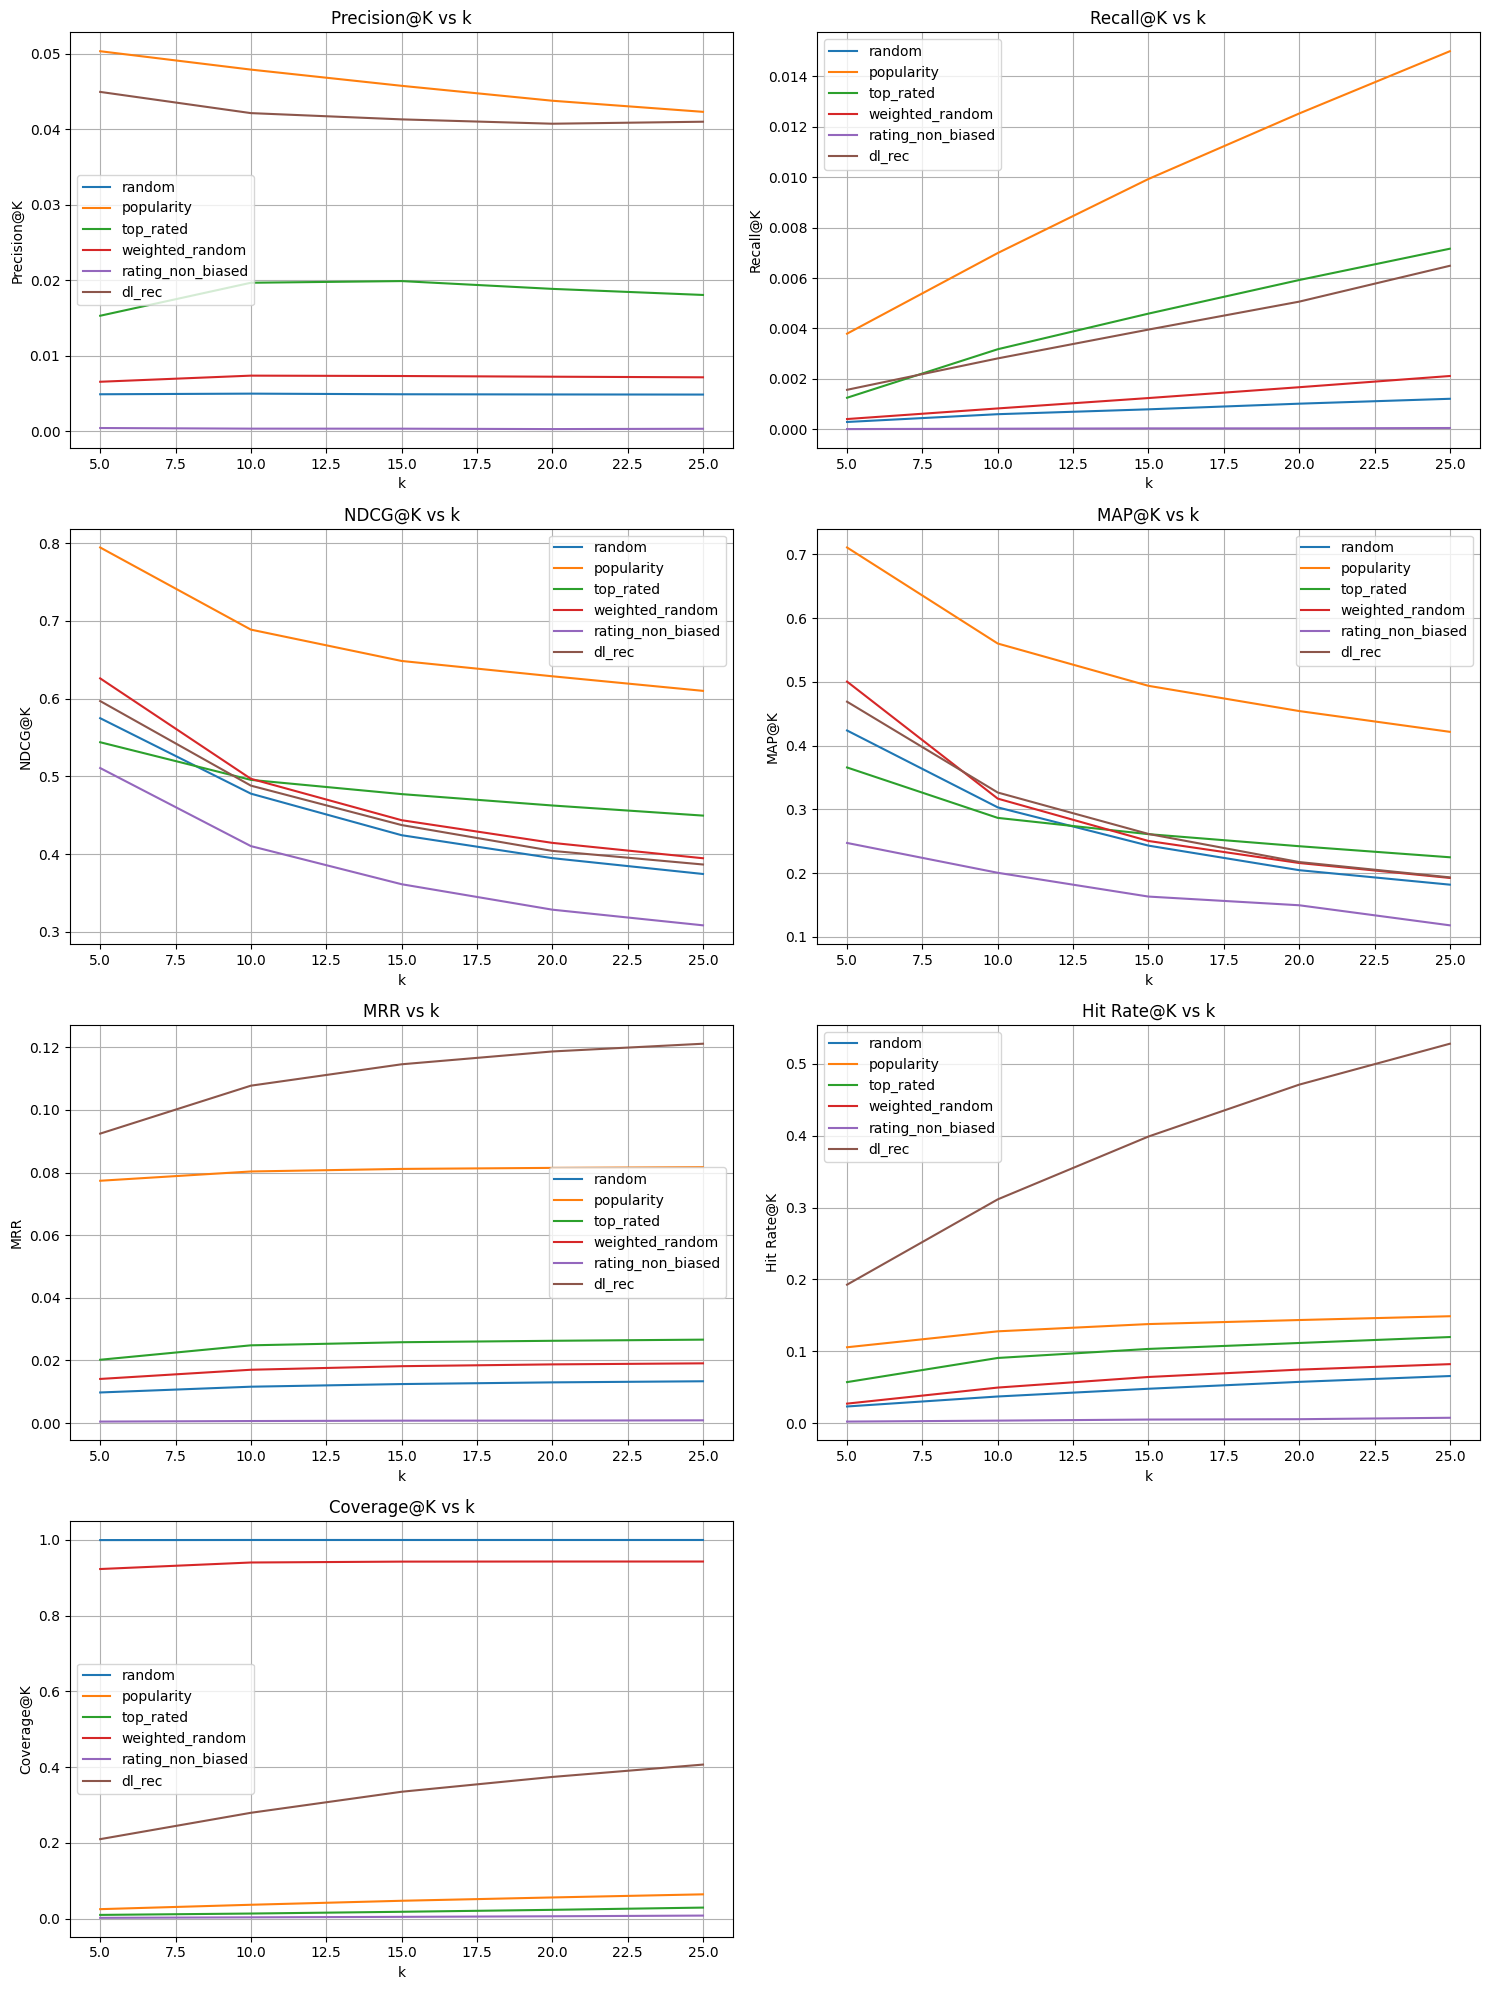

In [75]:
plot_metrics_grid(all_metrics,list(baseline_res['random'][25].keys()))

From the results above we can we observe that deep learning model can compete with popularity based method. 

We see that Hit Rate is much higher for the dl model, which means that we will more likely recommend at least one relevant item for users with dl model rather with popularity based.

However this is the only one metric which is outperformed by dl model, MRR and Precision are roughly the same, but dl model has noticable underperformence for MAP, NDCG and Recall, which means that we will have worse ranking and we will not have "complete" recommendations. 